<a href="https://colab.research.google.com/github/HageAnkha/SME-RFT-Predictor/blob/main/SME_Loan_Pre_Screening(RFT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt

In [12]:
import pandas as pd

file_path = "/content/drive/MyDrive/SME Loan Pre-Screen_Right-First-Time Applications.xlsx"

xls = pd.ExcelFile(file_path)
print(xls.sheet_names)   # Shows all sheet names

df = xls.parse(xls.sheet_names[0])   # Load first sheet
df.head()

['Loan Application DataSet']


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,NaN,S.No.,Applicant ID,Applicant's Industry,Loan Amount Requested,Loan Category,Applicant's Category,Income Document Submitted,KYC Submitted,Business Proof Submitted
1,NaN,1,SMEServ1,Services,1000000,SME,Large,Yes,Yes,Yes
2,NaN,2,SMETrad2,Trading,4500000,SME,Medium,No,No,No
3,NaN,3,SMETrad3,Trading,3100000,SME,Large,No,Yes,No
4,NaN,4,SMEServ4,Services,100000,SME,Medium,Yes,Yes,No


In [15]:
import pandas as pd

file_path = "/content/drive/MyDrive/SME Loan Pre-Screen_Right-First-Time Applications.xlsx"

# Load using row 1 as the header
df = pd.read_excel(file_path, sheet_name="Loan Application DataSet", header=1)

# Drop the first column (all NaN)
df = df.drop(columns=df.columns[0])

df.head()

,S.No.,Applicant ID,Applicant's Industry,Loan Amount Requested,Loan Category,Applicant's Category,Income Document Submitted,KYC Submitted,Business Proof Submitted
0,1,SMEServ1,Services,1000000,SME,Large,Yes,Yes,Yes
1,2,SMETrad2,Trading,4500000,SME,Medium,No,No,No
2,3,SMETrad3,Trading,3100000,SME,Large,No,Yes,No
3,4,SMEServ4,Services,100000,SME,Medium,Yes,Yes,No
4,5,SMEServ5,Services,1800000,SME,Large,Yes,Yes,Yes


we can see that no target column is present, therefore create an RFT (Right-First-Time) target column using a clear and logical rule:  
An application is RFT = 1 when aLL required documents are submitted:
(  Income Document Submitted = Yes
  KYC Submitted = Yes
  Business Proof Submitted = Yes)
............If any document is missing -> RFT = 0

## RFT (Right-First-Time) Target Column

In [16]:
# Convert Yes/No to consistent format
df[['Income Document Submitted', 'KYC Submitted', 'Business Proof Submitted']] = \
df[['Income Document Submitted', 'KYC Submitted', 'Business Proof Submitted']].replace({
    'Yes': 1,
    'No': 0
})

# Create Right-First-Time (RFT) target column
df['RFT'] = (
    (df['Income Document Submitted'] == 1) &
    (df['KYC Submitted'] == 1) &
    (df['Business Proof Submitted'] == 1)
).astype(int)

df.head()

/tmp/ipython-input-3781164517.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[['Income Document Submitted', 'KYC Submitted', 'Business Proof Submitted']].replace({


,S.No.,Applicant ID,Applicant's Industry,Loan Amount Requested,Loan Category,Applicant's Category,Income Document Submitted,KYC Submitted,Business Proof Submitted,RFT
0,1,SMEServ1,Services,1000000,SME,Large,1,1,1,1
1,2,SMETrad2,Trading,4500000,SME,Medium,0,0,0,0
2,3,SMETrad3,Trading,3100000,SME,Large,0,1,0,0
3,4,SMEServ4,Services,100000,SME,Medium,1,1,0,0
4,5,SMEServ5,Services,1800000,SME,Large,1,1,1,1


**Data Preprocessing**

In [22]:
# 1. DROP any ID or unnecessary indexing columns if they exist
cols_to_drop = ['S.No.', 'Applicant ID', 'Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2',
                'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6',
                'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

# 2. Convert YES/NO columns to binary
yes_no_cols = ['Income Document Submitted', 'KYC Submitted', 'Business Proof Submitted']

for col in yes_no_cols:
    if df[col].dtype == 'object':   # convert only if text
        df[col] = df[col].replace({"Yes": 1, "No": 0})

# 3. Convert Loan Amount to numeric
df['Loan Amount Requested'] = pd.to_numeric(df['Loan Amount Requested'], errors='coerce')

# 4. Create RFT target column
df['RFT'] = (
    (df['Income Document Submitted'] == 1) &
    (df['KYC Submitted'] == 1) &
    (df['Business Proof Submitted'] == 1)
).astype(int)

# 5. Fill any missing values (ideal for ML)
df = df.fillna(0)

# 6. Ensure dataset is fully numeric
df = df.apply(pd.to_numeric, errors='ignore')

# Show final dataset
df.head()

/tmp/ipython-input-1439162408.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


,Loan Amount Requested,Income Document Submitted,KYC Submitted,Business Proof Submitted,RFT,Applicant's Industry_Services,Applicant's Industry_Trading,Applicant's Category_Medium,Applicant's Category_Small
0,1000000,1,1,1,1,True,False,False,False
1,4500000,0,0,0,0,False,True,True,False
2,3100000,0,1,0,0,False,True,False,False
3,100000,1,1,0,0,True,False,True,False
4,1800000,1,1,1,1,True,False,False,False


In [21]:
df.columns.tolist()

['Loan Amount Requested',
 'Income Document Submitted',
 'KYC Submitted',
 'Business Proof Submitted',
 'RFT',
 "Applicant's Industry_Services",
 "Applicant's Industry_Trading",
 "Applicant's Category_Medium",
 "Applicant's Category_Small"]

**Logistic Regression Model / K-Fold Cross-Validation (Small Dataset)**

In [30]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# Features and target
X = df.drop(columns=['RFT'])
y = df['RFT']

# Initialize Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Stratified K-Fold
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to collect all true labels and predictions
all_y_true = []
all_y_pred = []

# Cross-validation loop
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train model
    lr_model.fit(X_train, y_train)

    # Predict on validation fold
    y_val_pred = lr_model.predict(X_val)

    # Collect results
    all_y_true.extend(y_val)
    all_y_pred.extend(y_val_pred)

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# Overall evaluation
print("Overall Accuracy:", accuracy_score(all_y_true, all_y_pred))
print("Overall Confusion Matrix:\n", confusion_matrix(all_y_true, all_y_pred))
print("\nOverall Classification Report:\n", classification_report(all_y_true, all_y_pred))

Overall Accuracy: 0.884
Overall Confusion Matrix:
 [[184  29]
 [  0  37]]

Overall Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.93       213
           1       0.56      1.00      0.72        37

    accuracy                           0.88       250
   macro avg       0.78      0.93      0.82       250
weighted avg       0.93      0.88      0.90       250



**Confusion Matrix**

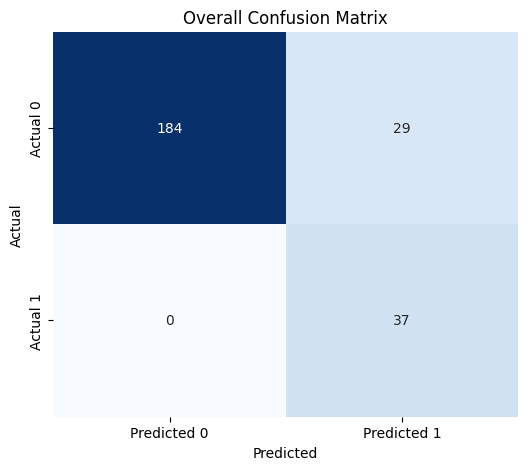

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0','Predicted 1'],
            yticklabels=['Actual 0','Actual 1'])
plt.title("Overall Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Predict Loan Eligibility**

In [34]:
# Example new application
new_app = {
    'Loan Amount Requested': 500000,
    'Income Document Submitted': 1,  # 1 = Yes, 0 = No
    'KYC Submitted': 1,
    'Business Proof Submitted': 1,
    "Applicant's Industry_Services": 1,
    "Applicant's Industry_Trading": 0,
    "Applicant's Category_Medium": 0,
    "Applicant's Category_Small": 0
}

# Convert to DataFrame (1 row)
new_app_df = pd.DataFrame([new_app])

# Predict probability
rft_proba = lr_model.predict_proba(new_app_df)[:,1]  # probability of RFT=1

# Predict class (0 = Not RFT, 1 = RFT)
rft_pred = lr_model.predict(new_app_df)

print(f"Predicted RFT (Right-First-Time): {rft_pred[0]}")
print(f"Probability of RFT: {rft_proba[0]:.2f}")

Predicted RFT (Right-First-Time): 1
Probability of RFT: 0.98


function that:
(
Takes raw applicant info,

Preprocesses it automatically (Yes/No → 1/0, one-hot encoding for categories),

Outputs RFT prediction and probability)

In [37]:
import pandas as pd

def predict_rft(new_app_raw, model, feature_columns):


    # 1. Convert Yes/No to 1/0
    for col in ['Income Document Submitted', 'KYC Submitted', 'Business Proof Submitted']:
        if col in new_app_raw:
            new_app_raw[col] = 1 if new_app_raw[col].strip().lower() == 'yes' else 0

    # 2. One-hot encode categorical features manually
    categorical_cols = {
        "Applicant's Industry": ["Applicant's Industry_Services", "Applicant's Industry_Trading"],
        "Applicant's Category": ["Applicant's Category_Medium", "Applicant's Category_Small"]
    }

    for cat_col, onehot_cols in categorical_cols.items():
        for col in onehot_cols:
            # Initialize all one-hot columns to 0
            new_app_raw[col] = 0
        # Set the corresponding category to 1
        if cat_col in new_app_raw:
            value = new_app_raw.pop(cat_col)
            if cat_col == "Applicant's Industry":
                if value == "Services":
                    new_app_raw["Applicant's Industry_Services"] = 1
                elif value == "Trading":
                    new_app_raw["Applicant's Industry_Trading"] = 1
            elif cat_col == "Applicant's Category":
                if value == "Medium":
                    new_app_raw["Applicant's Category_Medium"] = 1
                elif value == "Small":
                    new_app_raw["Applicant's Category_Small"] = 1
                # Large is all zeros

    # 3. Ensure all training features are present
    for col in feature_columns:
        if col not in new_app_raw:
            new_app_raw[col] = 0

    # 4. Convert to DataFrame
    new_app_df = pd.DataFrame([new_app_raw])[feature_columns]

    # 5. Predict RFT
    rft_pred = model.predict(new_app_df)[0]
    rft_proba = model.predict_proba(new_app_df)[:,1][0]

    return rft_pred, rft_proba

In [38]:
# Define the feature columns used for training
feature_cols = [
    'Loan Amount Requested',
    'Income Document Submitted',
    'KYC Submitted',
    'Business Proof Submitted',
    "Applicant's Industry_Services",
    "Applicant's Industry_Trading",
    "Applicant's Category_Medium",
    "Applicant's Category_Small"
]

# New application (raw form)
new_app = {
    'Loan Amount Requested': 500000,
    'Income Document Submitted': 'Yes',
    'KYC Submitted': 'Yes',
    'Business Proof Submitted': 'Yes',
    "Applicant's Industry": 'Services',
    "Applicant's Category": 'Large'
}

# Predict
rft_pred, rft_proba = predict_rft(new_app, lr_model, feature_cols)

print(f"Predicted RFT (Right-First-Time): {rft_pred}")
print(f"Probability of RFT: {rft_proba:.2f}")

Predicted RFT (Right-First-Time): 1
Probability of RFT: 0.98


# **Make a Simple Interactive Dashboard**

In [44]:
import ipywidgets as widgets
from IPython.display import display

loan_amount = widgets.IntText(value=1000000, description='Loan Amount')
income_doc = widgets.Dropdown(options=['Yes','No'], description='Income Doc')
kyc_doc = widgets.Dropdown(options=['Yes','No'], description='KYC')
business_proof = widgets.Dropdown(options=['Yes','No'], description='Business Proof')
industry = widgets.Dropdown(options=['Services','Trading'], description='Industry')
category = widgets.Dropdown(options=['Large','Medium','Small'], description='Category')
button = widgets.Button(description='Predict RFT')
output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        new_app = {
            'Loan Amount Requested': loan_amount.value,
            'Income Document Submitted': income_doc.value,
            'KYC Submitted': kyc_doc.value,
            'Business Proof Submitted': business_proof.value,
            "Applicant's Industry": industry.value,
            "Applicant's Category": category.value
        }
        rft_pred, rft_proba = predict_rft(new_app, lr_model, feature_cols)
        print(f"RFT Prediction: {'Yes' if rft_pred==1 else 'No'}")
        print(f"Probability: {rft_proba:.2f}")

button.on_click(on_button_clicked)

display(loan_amount, income_doc, kyc_doc, business_proof, industry, category, button, output)

IntText(value=1000000, description='Loan Amount')

Dropdown(description='Income Doc', options=('Yes', 'No'), value='Yes')

Dropdown(description='KYC', options=('Yes', 'No'), value='Yes')

Dropdown(description='Business Proof', options=('Yes', 'No'), value='Yes')

Dropdown(description='Industry', options=('Services', 'Trading'), value='Services')

Dropdown(description='Category', options=('Large', 'Medium', 'Small'), value='Large')

Button(description='Predict RFT', style=ButtonStyle())

Output()